# Backdoor v1: Using `Re78`

Using linear regression to model using a backdoor estimator on `Re78` before and after job training.

In [1]:
import sys

sys.path.append("../")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

from utils.backdoor_utils import backdoor_lr, backdoor_param_a, mean_diff_estimator
from utils.bootstrap import bootstrap, bootstrap_experiment
from utils.printing import signif

In [3]:
lalonde_exp = pd.read_csv("../data/lalonde_exp.csv")
lalonde_obs = pd.read_csv("../data/lalonde_psid.csv")

## Experimental Estimate

$Re_{78}^{a=1} - Re_{78}^{a=0}$

Here $a$ is just the experimental cohort. It is not the counterfactual.

In [4]:
mean_diff = (
    lalonde_exp.loc[lalonde_exp["treat"] == 1, "re78"].mean()
    - lalonde_exp.loc[lalonde_exp["treat"] == 0, "re78"].mean()
)
mean_diff

1794.3430848752596

Our point estimate on the experimental data is then roughly US$1794.3

In [5]:
n_values = range(10, 100, 10)
ci_results = []

for n in n_values:
    ci = bootstrap(
        lalonde_exp,
        mean_diff_estimator,
        n,
        95,
        treatment_col="treat",
        outcome_col="re78",
    )
    ci_results.append({"n": n, "mean": ci[0], "lower_ci": ci[1], "upper_ci": ci[2]})

In [6]:
ci_df = pd.DataFrame(ci_results)

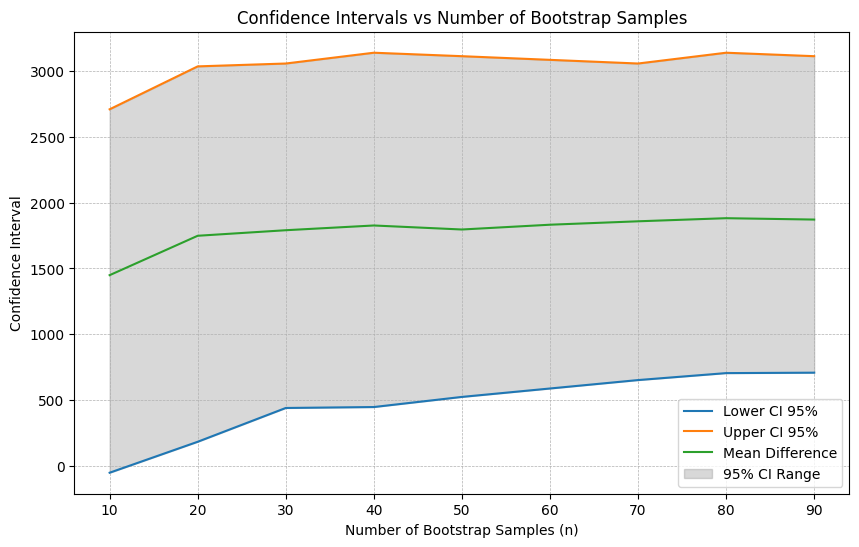

In [7]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="n", y="lower_ci", data=ci_df, label="Lower CI 95%")
sns.lineplot(x="n", y="upper_ci", data=ci_df, label="Upper CI 95%")
sns.lineplot(x="n", y="mean", data=ci_df, label="Mean Difference")
plt.fill_between(
    ci_df["n"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(n_values)
plt.xlabel("Number of Bootstrap Samples (n)")
plt.ylabel("Confidence Interval")
plt.title("Confidence Intervals vs Number of Bootstrap Samples")
plt.legend()
plt.show()

We can see that the CIs stabilize at around 50 samples, so we'll be using 50 samples to calculate our CI.

In [8]:
ci = bootstrap(
    lalonde_exp,
    mean_diff_estimator,
    50,
    95,
    treatment_col="treat",
    outcome_col="re78",
)

In [9]:
print(
    f"Causal estimate of `Re78` in experimental data as a difference of means is "
    f"US${ci[0]:.2f} ± [{ci[1]:.2f}, {ci[2]:.2f}]"
)

Causal estimate of `Re78` in experimental data as a difference of means is US$1796.24 ± [522.92, 3114.44]


## Backdoor Estimator

Assume $Y$ represents our outcome variable, i.e., `re78`. Our set of confounders is $Z=$ {`education, re74, re75, black, hispanic, married`}. $A$ is our intervention variable which represents `treat` or job training. Our derivation for the counterfactual function looks below:

\begin{align}
E[Y^a - Y^{a'}]
&= E[Y^a] - E[Y^{a'}] \tag{1}\\
&= p(Y^a) - p(Y^{a'}) \tag{2}\\
&= \sum_Z p(Y^a \mid z) p(z) - \sum_Z p(Y^{a'} \mid z) p(z) \tag{3}\\
&= \sum_Z p(Y^a \mid a, z) p(z) - \sum_Z p(Y^{a'} \mid a', z) p(z) \tag{4}\\
&= \sum_Z p(Y \mid a, z) p(z) - \sum_Z p(Y \mid a', z) p(z) \tag{5} \\
&= \sum_Z p(z) [p(Y \mid a, z) - p(Y \mid a', z)] \tag{6}
\end{align}

1. Linearity of expectation.
2. Equivalence of expectation and probabilities.
3. Marginalizing over $Z$.
4. Using conditional exchangeability: $p(Y^a \mid a, z) = p(Y \mid a, z)$.
5. Using consistency: $p(Y^a \mid a, z) = p(Y \mid a, z)$.

### Using difference of Means in LR

* Factors such as `education` and `nodegree` form a perfect association among each other.
* This would either cause our matrix solution to be non-singular (i.e. no solution) or prevent gradient descent from converging.
* The confounders below do not share perfect associations.

In [10]:
backdoor_result = backdoor_lr(
    lalonde_exp,
    "treat",
    "re78",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)
print(
    f"The difference between the treatment and no-treatment groups is {backdoor_result:.2f}."
)

The difference between the treatment and no-treatment groups is 1632.64.


* Now we'll run a set of bootstrap experiments
* We're running `num_exp` experiments each with `n` bootstrap samples to see how spread our confidence intervals are.
* The width of the confidence interval gives you an idea of the variability or precision of our estimator.
* Running multiple bootstrap experiments would allow us to check the consistency of our estimator.
* We can later use synthetic data to compare the mean of our boostrap experiment to the known true value to check the bias of our estimate.
* Finally, if our estimates remain stable despite resampling, it indicates that our model appropriately adjusts for confounders.

In [11]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_exp,
    function=backdoor_lr,
    num_exp=50,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.79it/s]


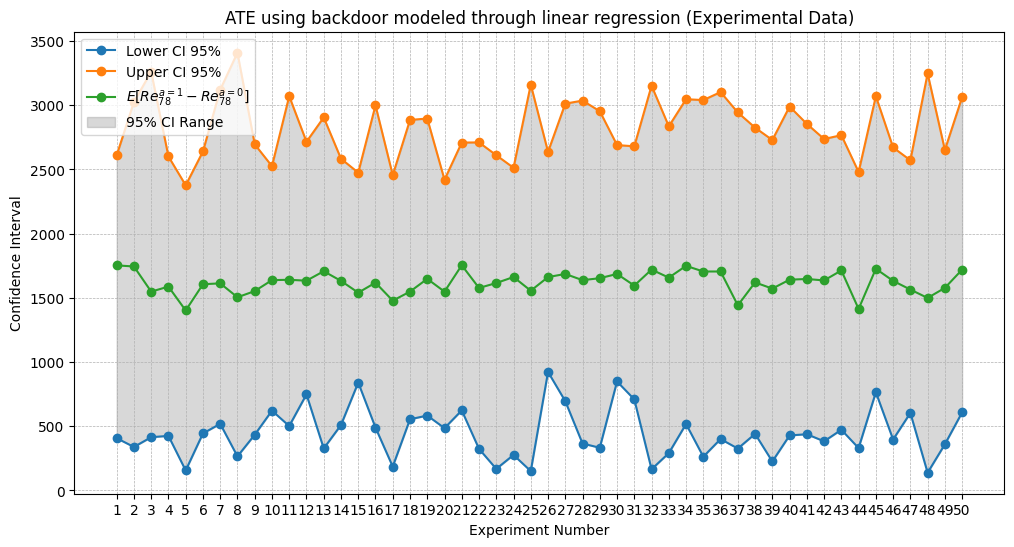

In [12]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(
    ci_df["experiment"],
    ci_df["mean"],
    label="$E[Re_{78}^{a=1} - Re_{78}^{a=0}]$",
    marker="o",
)

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("ATE using backdoor modeled through linear regression (Experimental Data)")
plt.legend()
plt.show()

In [13]:
ci_df.sample(10)

,mean,lower_ci,upper_ci,experiment
24,1555.873632,150.946338,3161.014321,25
22,1615.632520,168.283163,2611.189527,23
18,1648.290597,583.752296,2896.859487,19
38,1572.199611,226.027462,2729.407149,39
35,1705.530509,400.715786,3102.688739,36
47,1499.541306,138.403920,3247.672199,48
17,1548.869122,554.558369,2885.795734,18
39,1641.824989,428.796316,2989.974511,40
29,1686.362865,848.917126,2690.069230,30
40,1647.106947,438.304911,2854.979450,41


* The mean looks fairly consistent and so do the CIs
* There are a few outlier experiments with slightly wider CIs.

In [14]:
ci = bootstrap(
    lalonde_exp,
    backdoor_lr,
    50,
    95,
    treatment_col="treat",
    outcome_col="re78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

print(
    f"Causal estimate of `Re78` in experimental data as a difference of means is "
    f"US${ci[0]:.2f} ± [{ci[1]:.2f}, {ci[2]:.2f}]"
)

Causal estimate of `Re78` in experimental data as a difference of means is US$1659.53 ± [153.80, 2878.54]


* This CI looks very wide, but the estimate seems fairly unbiased.
* This suggests that our backdoor estimator might be a high variance estimate.

## Using a's parameters

Assume $\beta$ is our causal risk difference. Let's assume that the relationship among Y, A and its confounders are linear. Using our previous estimate we now have:

\begin{align}
\beta
&= \sum_Z p(z) [E(Y \mid a, z) - E(Y \mid a', z)] \tag{1} \\
&= \frac{1}{N} \sum_{i}^{N} [E(Y \mid a, Z_{i}) - E(Y \mid a', Z_{i})] \tag{2} \\
&= \frac{1}{N} \sum_{i}^{N} [(\omega_0 + \omega_{A} \cdot 1 + \omega_{Z}Z) - (\omega_0 + \omega_{A} \cdot 0 + \omega_{Z}Z)] \tag{3} \\
&= \frac{1}{N} \sum_{i}^{N} \omega_{A} \tag{4} \\
&= \omega_{A} \tag{5}
\end{align}

1. Relating expectations to probabilities.
2. Using the uniform distribution of $p(Z_i)$.
3. Linear regression modeling where $A = \{0, 1\}$.
4. Simplifying to isolate $\omega_A$.
5. Resulting in $\omega_A$ representing the causal risk difference.

* Hence we're only interested in the parameters of $\omega_A$ for our causal risk difference.
* This assumes for an increase in $a$, our counterfactual $\beta$ would proportionally increase by $\omega_A$.
* This is another way we can assess our causal risk difference.

In [15]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_exp,
    function=backdoor_param_a,
    num_exp=50,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.41it/s]


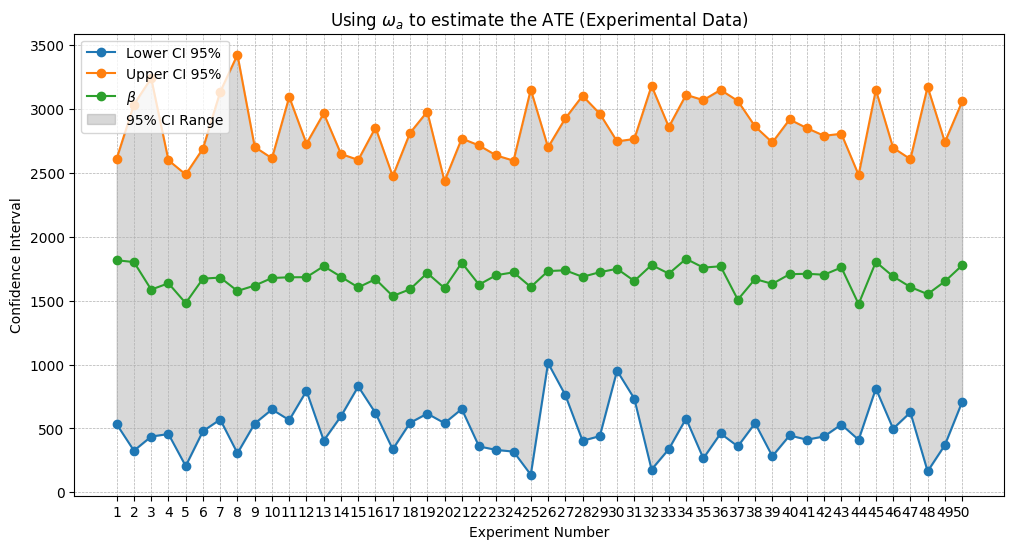

In [16]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="$\\beta$", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Using $\\omega_{a}$ to estimate the ATE (Experimental Data)")
plt.legend()
plt.show()

In [17]:
ci_df.sample(10)

,mean,lower_ci,upper_ci,experiment
24,1606.474767,137.511205,3151.704196,25
22,1698.962773,331.624078,2636.233175,23
18,1715.585062,615.663368,2978.867314,19
38,1630.863637,282.418115,2737.563872,39
35,1768.462949,460.326911,3148.854386,36
47,1550.501682,164.150180,3173.824847,48
17,1588.710782,543.494148,2811.787652,18
39,1706.506887,444.833178,2917.497145,40
29,1748.968722,951.558715,2746.104457,30
40,1710.089333,411.806251,2850.052301,41


In [18]:
ci = bootstrap(
    lalonde_exp,
    backdoor_param_a,
    50,
    95,
    treatment_col="treat",
    outcome_col="re78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

print(
    f"Causal estimate of `Re78` in experimental data as a difference of means is "
    f"US${ci[0]:.2f} ± [{ci[1]:.2f}, {ci[2]:.2f}]"
)

Causal estimate of `Re78` in experimental data as a difference of means is US$1706.91 ± [211.21, 2918.73]


To check if our estimates are biased and check their variances, we need to run our estimates on observational data.

## Using Observational data

### Näive difference of means

In [19]:
mean_diff = (
    lalonde_obs.loc[lalonde_obs["treat"] == 1, "re78"].mean()
    - lalonde_obs.loc[lalonde_obs["treat"] == 0, "re78"].mean()
)
mean_diff

-15204.775555988717

### Backdoor Estimate

Running our backdoor estimate on observational data.

In [20]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_obs,
    function=backdoor_lr,
    num_exp=50,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:45<00:00,  1.09it/s]


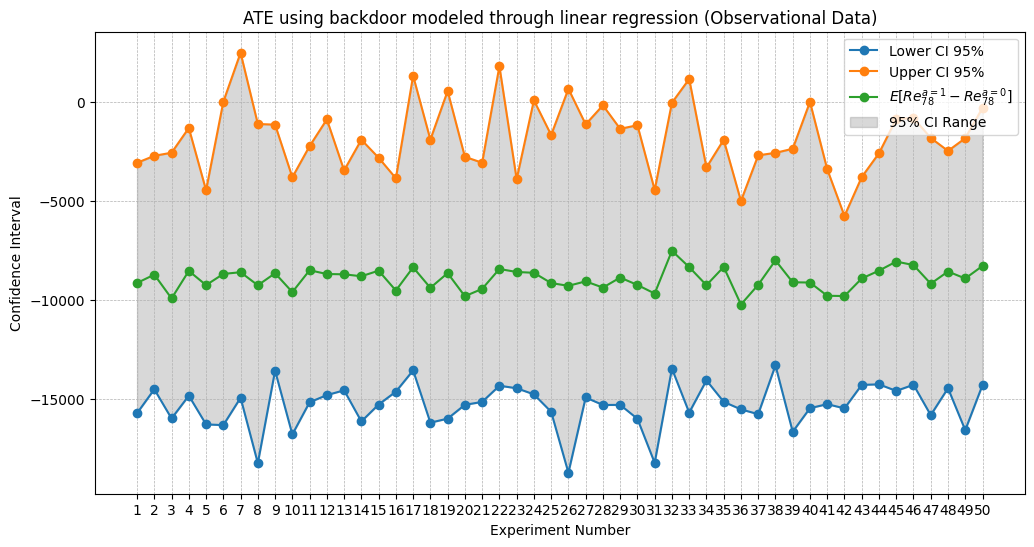

In [21]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(
    ci_df["experiment"],
    ci_df["mean"],
    label="$E[Re_{78}^{a=1} - Re_{78}^{a=0}]$",
    marker="o",
)

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("ATE using backdoor modeled through linear regression (Observational Data)")
plt.legend()
plt.show()

In [22]:
ci_df.sample(10)

,mean,lower_ci,upper_ci,experiment
49,-8287.192185,-14305.863810,-299.738923,50
26,-9066.107634,-14933.780308,-1131.401875,27
27,-9380.450252,-15312.345537,-171.984061,28
32,-8345.583859,-15697.624167,1158.631354,33
9,-9609.899052,-16801.150022,-3805.919208,10
45,-8242.913313,-14290.969461,-816.497336,46
13,-8807.639779,-16144.021281,-1908.833186,14
23,-8633.734761,-14774.817566,81.359122,24
48,-8921.455675,-16583.158585,-1832.391362,49
46,-9183.848233,-15825.151076,-1819.115797,47


The above estimate is both high bias and high variance.

In [23]:
ci = bootstrap(
    lalonde_obs,
    backdoor_lr,
    50,
    95,
    treatment_col="treat",
    outcome_col="re78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

print(
    f"Causal estimate of `Re78` in observational data as a difference of means is "
    f"US${ci[0]:.2f} ± [{ci[1]:.2f}, {ci[2]:.2f}]"
)

Causal estimate of `Re78` in observational data as a difference of means is US$-9200.54 ± [-15795.52, -2132.38]


### Using a's parameters

In [24]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_obs,
    function=backdoor_param_a,
    num_exp=50,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


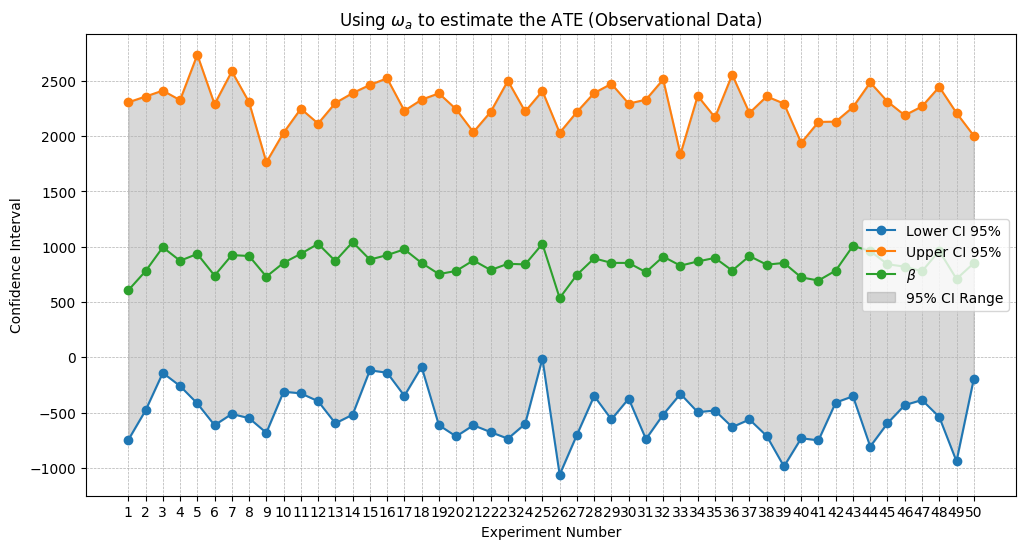

In [25]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="$\\beta$", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Using $\\omega_{a}$ to estimate the ATE (Observational Data)")
plt.legend()
plt.show()

In [26]:
ci_df.sample(10)

,mean,lower_ci,upper_ci,experiment
4,934.553166,-418.039681,2736.734838,5
3,873.135022,-260.209180,2326.009033,4
40,694.236767,-751.307149,2128.835684,41
16,976.163294,-349.015896,2229.888274,17
47,962.279575,-539.995502,2445.731449,48
48,708.667977,-941.231431,2209.887918,49
18,752.554963,-613.979904,2387.396209,19
19,780.650551,-715.896283,2243.743517,20
12,870.520613,-597.538654,2300.277293,13
0,605.853077,-747.828633,2306.098058,1


In [27]:
ci = bootstrap(
    lalonde_obs,
    backdoor_param_a,
    50,
    95,
    treatment_col="treat",
    outcome_col="re78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

print(
    f"Causal estimate of `Re78` in observational data as a difference of means is "
    f"US${ci[0]:.2f} ± [{ci[1]:.2f}, {ci[2]:.2f}]"
)

Causal estimate of `Re78` in observational data as a difference of means is US$861.24 ± [-549.37, 2379.72]


This is less biased and has less variance than our previous backdoor estimate on our observational data.

Finally, we're re-running the model to get model parameters for the final report:

In [28]:
def backdoor_param_a_model(df, treatment_col, outcome_col, confounder_cols):
    formula = f"{outcome_col} ~ {treatment_col} + " + " + ".join(confounder_cols)
    model = smf.ols(formula=formula, data=df).fit()
    return model

In [29]:
param_a_model = backdoor_param_a_model(
    df=lalonde_obs,
    treatment_col="treat",
    outcome_col="re78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

In [30]:
for param_name, param_value in param_a_model.params.items():
    rounded_value = signif(param_value, 3)
    print(f"{param_name}: {rounded_value}")

Intercept: 777.0
treat: 860.0
age: -81.5
education: 528.0
black: -543.0
hispanic: 2170.0
married: 1220.0
re74: 0.278
re75: 0.568
